In [2]:
# imports used by more than one cell
import logging
import warnings
from pathlib import Path
from matplotlib import pyplot
import numpy as np
import rasterio as rio
from tqdm.auto import tqdm

import geedim as gd

logging.basicConfig(level=logging.ERROR)

In [30]:
from glob import glob
# source captured from 2010-01-22 - 2010-02-01
src_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Source/'
    'GroundTruthSubset'
)
src_mosaic_path = src_root.joinpath(
    'NGI_3321BD-3322AC_2010_LittleKaroo_GroundTruthSubset_Source.vrt'
)
src_paths = [
    Path(src_path) 
    for src_path in glob(str(src_root.joinpath('*_RGBN_CMP.tif')))
]

ref_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Reference/'
    'GroundTruthSubset'
)
ref_path = ref_root.joinpath('l7_comp_ref.tif')

# create a search region that covers the source image mosaic
region = gd.utils.get_bounds(src_mosaic_path)


In [31]:
gd.Initialize()

# create and search the Landsat-7 collection
gd_coll = gd.MaskedCollection.from_name('LANDSAT/LE07/C02/T1_L2')
gd_coll = gd_coll.search(
    '2010-01-01', '2010-02-28', region, cloudless_portion=50
)
print('Image property descriptions:\n\n' + gd_coll.schema_table)
print('\nSearch Results:\n\n' + gd_coll.properties_table)

# equivalent geedim command line:
# !geedim search -c l7-c2-l2 -s 2010-01-01 -e 2010-02-28-cp 50  -r {src_mosaic_path}

Image property descriptions:

ABBREV     NAME                  DESCRIPTION
---------  --------------------  ---------------------------------------
ID         system:id             Earth Engine image id
DATE       system:time_start     Image capture date/time (UTC)
FILL       FILL_PORTION          Portion of valid pixels (%)
CLOUDLESS  CLOUDLESS_PORTION     Portion of cloud/shadow free pixels (%)
GRMSE      GEOMETRIC_RMSE_MODEL  Orthorectification RMSE (m)
SAA        SUN_AZIMUTH           Solar azimuth angle (deg)
SEA        SUN_ELEVATION         Solar elevation angle (deg)

Search Results:

ID                                          DATE              FILL CLOUDLESS GRMSE   SAA   SEA
------------------------------------------- ---------------- ----- --------- ----- ----- -----
LANDSAT/LE07/C02/T1_L2/LE07_173083_20100203 2010-02-03 08:14 92.12     92.10  4.74 73.32 52.10
LANDSAT/LE07/C02/T1_L2/LE07_173083_20100219 2010-02-19 08:14 92.01     92.01  4.58 66.61 49.04


In [7]:
# create a composite of search results to fill in SLE gaps
comp_im = gd_coll.composite(
    gd.CompositeMethod.q_mosaic, date='2010-01-27', 
    resampling=gd.ResamplingMethod.bilinear,
)

# download
with rio.open(src_mosaic_path, 'r') as ds:
    src_crs = ds.crs.to_wkt()

comp_im.download(ref_path, crs=src_crs, scale=30, region=region)

l7_comp_ref.tif: |                                             | 0.00/184M (raw) [  0.0%] in 00:00 (eta:     ?…

In [32]:
from homonim import RasterFuse, Model, ProcCrs, utils
# corrected file names corresponding to source names
model = Model.gain_blk_offset
kernel_shape = (5, 5)
corr_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Corrected/'
    'GroundTruthSubset'
)
post_fix = utils.create_out_postfix(
    ProcCrs.ref, model=model, kernel_shape=kernel_shape, driver='GTiff'
)
corr_paths = [
    corr_root.joinpath(src_path.stem + post_fix)
    for src_path in src_paths
]
ref_bands = [3, 2, 1, 4]

In [19]:
for src_path, corr_path in zip(src_paths, corr_paths):
    with RasterFuse(src_path, ref_path, ref_bands=ref_bands) as raster_fuse:
        print(f'{corr_path.name}:')
        raster_fuse.process(
            corr_path, Model.gain_blk_offset, (5, 5), 
            block_config=dict(threads=2, max_block_mem=256), 
            out_profile=dict(dtype='uint16', nodata=0), 
            model_config=dict(mask_partial=False), 
            overwrite=True
        )

3321b_3172_12_0415_rgbn_CMP_FUSE_cREF_mGAIN-BLK-OFFSET_k5_5.tif:


  0%|                                                                                     |0/8 blocks [00:00<?…

3321b_3172_12_0419_rgbn_CMP_FUSE_cREF_mGAIN-BLK-OFFSET_k5_5.tif:


  0%|                                                                                     |0/8 blocks [00:00<?…

3321D_319_04_0121_RGBN_CMP_FUSE_cREF_mGAIN-BLK-OFFSET_k5_5.tif:


  0%|                                                                                     |0/8 blocks [00:00<?…

3322c_322_02_0056_rgbn_CMP_FUSE_cREF_mGAIN-BLK-OFFSET_k5_5.tif:


  0%|                                                                                     |0/8 blocks [00:00<?…

In [33]:
from osgeo import gdal

# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
corr_mosaic_path = corr_root.joinpath(
    f'NGI_3321BD-3322AC_2010_LittleKaroo_GroundTruthSubset{post_fix[:-4]}.vrt'
)
ds = gdal.BuildVRT(
    str(corr_mosaic_path.absolute()), [str(cp) for cp in corr_paths]
)
ds.FlushCache()

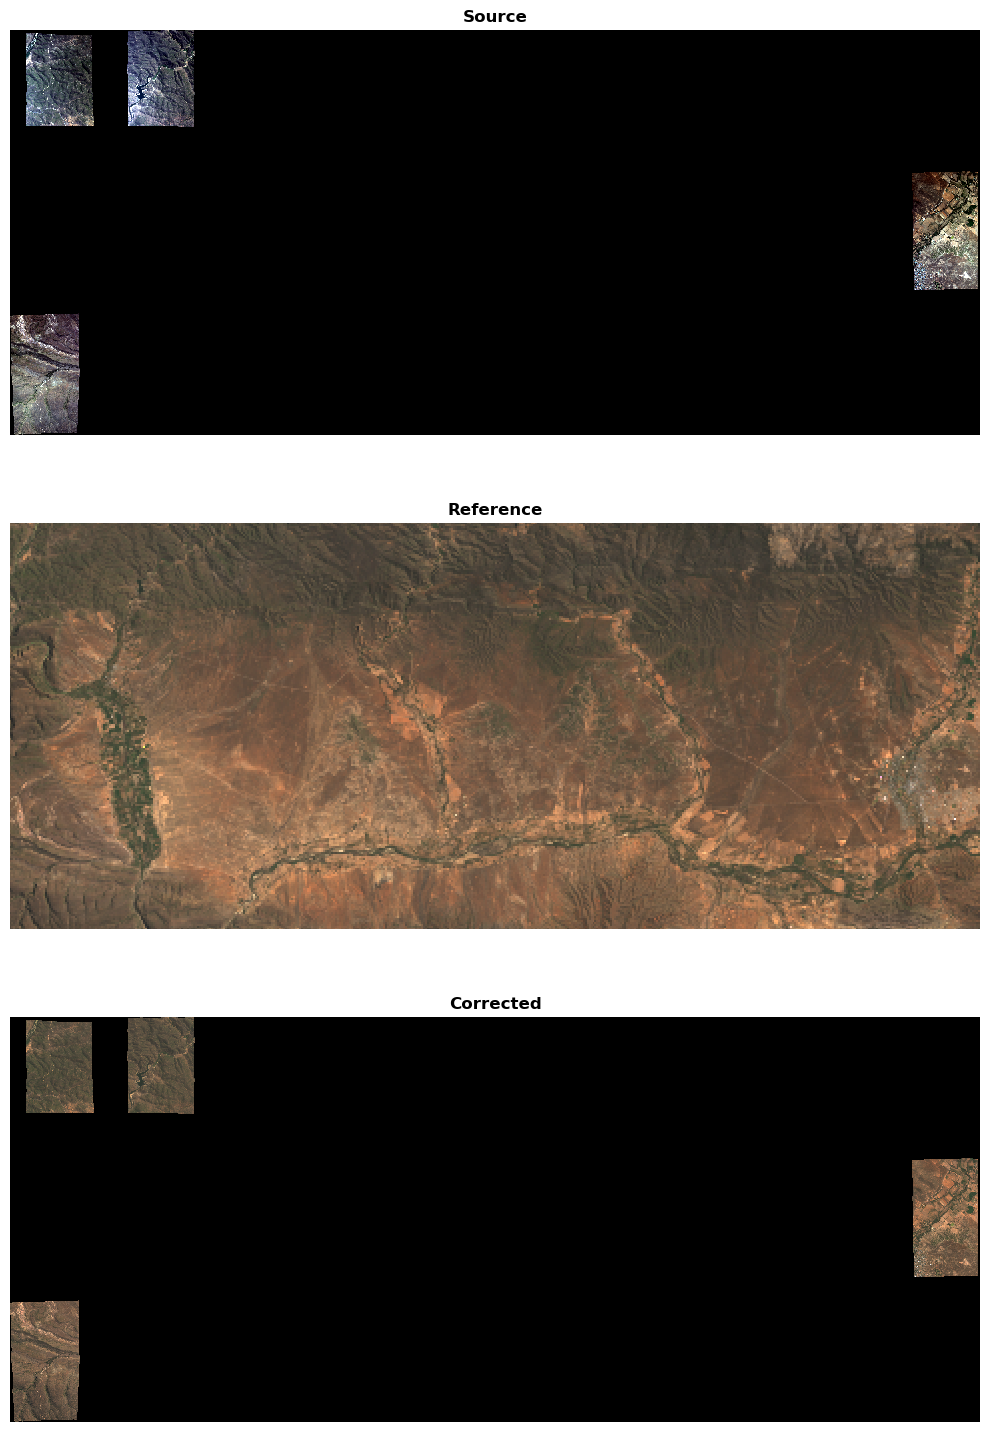

In [25]:
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
from rasterio.plot import show
# VRT mosaic of the source files

fig, axes = pyplot.subplots(
    3, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10, 15), 
    dpi=100
)

for im_file, ds_fact, indexes, sc_off, ax, label in zip(
    [src_mosaic_path, ref_path, corr_mosaic_path],
    [16, 4, 16],                           # downsample factor
    [None, ref_bands, None],               # band indices
    [None, [12e3, .5], [12e3, .5]],  # colour scale & offset
    axes,
    ['Source', 'Reference', 'Corrected'], 
):
    # read, scale and display the image
    with rio.open(im_file, 'r') as ds:
        ds_shape = tuple(np.round(np.array(ds.shape) / ds_fact).astype('int'))
        transform = ds.transform * rio.Affine.scale(ds_fact)

        array = ds.read(indexes=indexes, out_dtype='float32', out_shape=ds_shape)

        # change nodata value to nan
        mask = np.any((array == ds.nodata) | np.isnan(array), axis=(0))
        array[:, mask] = np.nan
        
        if sc_off is not None:
            # scale and offset pixel values
            array = np.clip((array / sc_off[0]) - sc_off[1], 0, 1)
        else:
            # 'normalise' image 2%-98% -> 0-1
            for bi in range(array.shape[0]):
                array[bi] -= np.nanpercentile(array[bi], 1)
                array[bi] /= np.nanpercentile(array[bi], 99)
                array[bi] = np.clip(array[bi], 0, 1)

    ax = show(array[0:3], transform=transform, interpolation='nearest', ax=ax)

    ax.set_title(label, fontweight='bold')
    ax.axis('off')

In [35]:
# search the MODIS NBAR collection
gd_coll = gd.MaskedCollection.from_name('MODIS/006/MCD43A4')
gd_coll = gd_coll.search(
    '2022-01-27', '2022-01-28', region, 
)
print('Image property descriptions:\n\n' + gd_coll.schema_table)
print('\nSearch Results:\n\n' + gd_coll.properties_table)

# download LANDSAT/LC08/C02/T1_L2/LC08_009057_20220215 
cmp_ref_path = ref_root.joinpath('modis_nbar_ref.tif')
gd_image = gd.MaskedImage.from_id(
    'MODIS/006/MCD43A4/2010_01_27', mask=True
)
gd_image.download(cmp_ref_path, region=region, overwrite=True)

# equivalent geedim command line:
# !geedim search -c modis-nbar -s 2010-01-27 -e 2010-01-28 -r {src_mosaic_path} download -o

Image property descriptions:

ABBREV  NAME               DESCRIPTION
------  -----------------  -----------------------------
ID      system:id          Earth Engine image id
DATE    system:time_start  Image capture date/time (UTC)
FILL    FILL_PORTION       Portion of valid pixels (%)

Search Results:

ID                           DATE             FILL
---------------------------- ---------------- ----
MODIS/006/MCD43A4/2022_01_27 2022-01-27 00:00  100


modis_nbar_ref.tif: |                                          | 0.00/278k (raw) [  0.0%] in 00:00 (eta:     ?…

In [40]:
from homonim import RasterCompare

print(RasterCompare.schema_table())

# loop over the source and corrected image files
for im_path, im_label in zip(
    [src_mosaic_path, corr_mosaic_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(
        im_path, cmp_ref_path, ref_bands=[1, 4, 3, 2],
    ) as compare:
        # print a table of comparison statistics (the typical way of using 
        # RasterCompare)
        print(f'{im_label}:')
        stats_dict = compare.process()
        print(f'{im_label} comparison:\n\n' + compare.stats_table(stats_dict))

    # equivalent homonim command line:
    # !homonim compare {im_path} {cmp_ref_path}

ABBREV DESCRIPTION
------ -----------------------------------------
r²     Pearson's correlation coefficient squared
RMSE   Root Mean Square Error
rRMSE  Relative RMSE (RMSE/mean(ref))
N      Number of pixels
Source:


  0%|                                                                                   |0/240 blocks [00:00<?…

Source comparison:

                   Band    r²     RMSE rRMSE   N
----------------------- ----- -------- ----- ---
Nadir_Reflectance_Band1 0.319  869.645 0.695 513
Nadir_Reflectance_Band4 0.209  355.283 0.362 513
Nadir_Reflectance_Band3 0.044  154.774 0.264 513
Nadir_Reflectance_Band2 0.206 1436.639 0.620 513
                   Mean 0.195  704.085 0.485 513
Corrected:


  0%|                                                                                   |0/240 blocks [00:00<?…

Corrected comparison:

                   Band    r²      RMSE  rRMSE   N
----------------------- ----- --------- ------ ---
Nadir_Reflectance_Band1 0.838  9818.392  7.845 513
Nadir_Reflectance_Band4 0.799  9233.679  9.412 513
Nadir_Reflectance_Band3 0.747  8695.272 14.806 513
Nadir_Reflectance_Band2 0.857 11862.759  5.117 513
                   Mean 0.810  9902.525  9.295 513
